# Edge detection of fishing net

In [1]:
%matplotlib inline
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys
import math
import os
from glob import glob

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  
  
opencv image -> BGR not RBG  
so we need to change its order

In [2]:
ori_dir = [y for x in os.walk('./original_img/Untorn_for_aug') for y in glob(os.path.join(x[0], '*.png'))]

In [3]:
print(ori_dir)

['./original_img/Untorn_for_aug/img0007.png', './original_img/Untorn_for_aug/img0004.png', './original_img/Untorn_for_aug/img0000.png', './original_img/Untorn_for_aug/img0005.png', './original_img/Untorn_for_aug/img0006.png', './original_img/Untorn_for_aug/img0001.png', './original_img/Untorn_for_aug/img0002.png', './original_img/Untorn_for_aug/img0003.png']


In [4]:
selected = 2
save_dir_for = '/detection_data/Torn/'
save_dir_mid = save_dir_for + ori_dir[selected].split('/')[-1].replace('.png', '/')
print(save_dir_mid)

/detection_data/Torn/img0000/


In [31]:
test = '0_Torn_0_103_191_391.png'
test1 = test.split('/')[-1].replace('.png','').split('_')
print(test1)

['0', 'Torn', '0', '103', '191', '391']


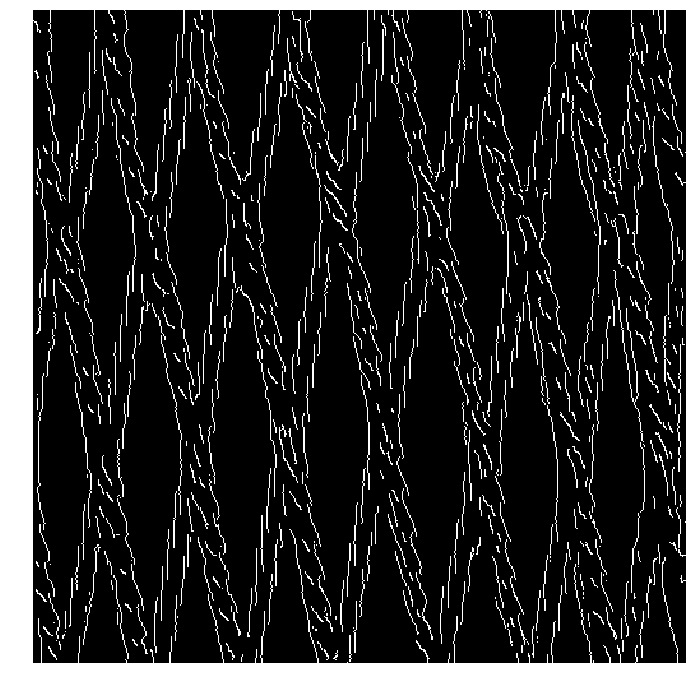

./original_img/Untorn_for_aug/img0000.png


In [23]:
save_dir_for = '/detection_data/Torn/'
saving_size = [512, 512]
gen_num = 150


save_dir_mid = save_dir_for + ori_dir[selected].split('/')[-1].replace('.png', '/')
img = cv2.imread(ori_dir[selected])
img = cv2.resize(img, (saving_size[0], saving_size[1]), interpolation=cv2.INTER_CUBIC)
blur = cv2.GaussianBlur(img, (9,9), 7, 7)
edges = cv2.Canny(blur, 80, 100)



width = 12
height = 12
plt.figure(figsize=(width, height))
plt.axis("off")
plt.imshow(edges, cmap="gray")
plt.show()

print(ori_dir[selected])

In [24]:
# For further usage
#cedges = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
cedges = np.copy(img)
cedgesP = np.copy(cedges)

./original_img/Untorn_for_aug/img0007.png - threshold 10, 50  
cont_width = 8  
  
./original_img/Untorn_for_aug/img0004.png - threshold 10, 50  
cont_width = 10  
  
./original_img/Untorn_for_aug/img0000.png - threshold 80, 100  
cont_width = 20

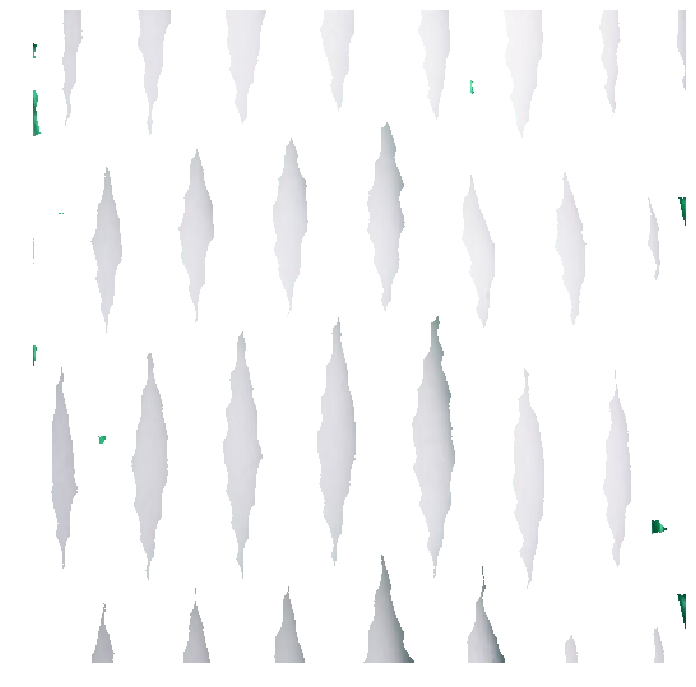

In [27]:
cont_width = 20

temp = img
con_img, contours, hierachy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
con_img = cv2.drawContours(temp, contours, -1, (255,255,255), cont_width)


width = 12
height = 12
plt.figure(figsize=(width, height))
plt.axis("off")
plt.imshow(cv2.cvtColor(con_img, cv2.COLOR_BGR2RGB))
plt.show()

#cv2.imwrite(filename, con_img)

# Background Inpainting

In [28]:
# Make black image for mask

blank_img = np.zeros((img.shape[0],img.shape[1], 1), np.uint8)
masks = cv2.drawContours(blank_img, contours, -1, (255,255,255), cont_width)

mask_idx = np.where(masks == 255)
y = np.array(mask_idx[0])
x = np.array(mask_idx[1])

## Generating

sample_num is the number of data which will be generated

In [33]:
for num in range(150, 200):
    blank_img2 = np.zeros((img.shape[0],img.shape[1], 1), np.uint8)

    # random ellipse center inside the image
    # Image shape -> Y, X, Channel
    # But when we draw something, X, Y coordinate
    center = np.array((int(np.random.choice(x, size=1)), int(np.random.choice(y, size=1))))

    minaxis = 11
    maxaxis = 200
    ax_flag = True

    while ax_flag is True:
        temp_ax = np.array((np.random.randint(minaxis, maxaxis, size=1), np.random.randint(minaxis, maxaxis, size=1)))

        if temp_ax[0] is not temp_ax[1]:
            ax_flag = False
    temp_ax = np.sort(temp_ax, axis=0)
    axes = np.array((temp_ax[1], temp_ax[0]))

    angle = np.random.randint(180, size=1)


    startA = np.random.randint(360, size=1)
    endA = startA + np.random.randint(360, size=1)
    if endA > 360:
        endA = endA - 360



    masks2 = cv2.ellipse(blank_img2, (center[0], center[1]), (axes[0], axes[1]), angle, startA, endA, (255,255,255), -1)

    white_idx = np.where(masks2 == 255)


    masks3 = np.zeros((img.shape[0],img.shape[1], 1), np.uint8)

    for i in range(0, len(white_idx[0])):
        if masks[white_idx[0][i], white_idx[1][i], 0] == 255:
            masks3[white_idx[0][i], white_idx[1][i], 0] = 255

    # Bounding box
    target = np.where(masks3 == 255)
    b_box1 = (min(target[1]), min(target[0]))
    b_box2 = (max(target[1]), max(target[0]))

    save_dir = save_dir_mid + '%d_Torn_%d_%d_%d_%d.png'%(num, b_box1[0], b_box1[1], b_box2[0], b_box2[1])
    save_dir_bb = save_dir_mid + '%d_bbTorn_%d_%d_%d_%d.png'%(num, b_box1[0], b_box1[1], b_box2[0], b_box2[1])

    # Make black image for mask
    width = 12
    height = 12

    img_ori = cv2.imread(ori_dir[selected], -1)
    img_ori = cv2.resize(img_ori, (saving_size[0], saving_size[1]), interpolation=cv2.INTER_CUBIC)

    new_img = cv2.inpaint(img_ori, masks3, 3, cv2.INPAINT_TELEA)

    cv2.imwrite(save_dir, new_img)

    b_img = new_img
    bb_img = cv2.rectangle(b_img, b_box1, b_box2, (0,0,225), 3)
    cv2.imwrite(save_dir_bb, bb_img)

In [ ]:
print(save_dir_mid)
save_dir = save_dir_mid + 'Torn_%d_%d_%d_%d.png'%(b_box1[0], b_box1[1], b_box2[0], b_box2[1])
print(save_dir)

In [ ]:
plt.figure(figsize=(width, height))
plt.axis("off")
plt.imshow(cv2.cvtColor(masks3, cv2.COLOR_GRAY2RGB))
plt.show()


plt.figure(figsize=(width, height))
plt.axis("off")
plt.imshow(cv2.cvtColor(bb_img, cv2.COLOR_BGR2RGB))
plt.show()


In [ ]:
for num in range(gen_num):
    blank_img2 = np.zeros((img.shape[0],img.shape[1], 1), np.uint8)

    # random ellipse center inside the image
    # Image shape -> Y, X, Channel
    # But when we draw something, X, Y coordinate
    center = np.array((int(np.random.choice(x, size=1)), int(np.random.choice(y, size=1))))

    minaxis = 11
    maxaxis = 200
    ax_flag = True

    while ax_flag is True:
        temp_ax = np.array((np.random.randint(minaxis, maxaxis, size=1), np.random.randint(minaxis, maxaxis, size=1)))

        if temp_ax[0] is not temp_ax[1]:
            ax_flag = False
    temp_ax = np.sort(temp_ax, axis=0)
    axes = np.array((temp_ax[1], temp_ax[0]))

    angle = np.random.randint(180, size=1)


    startA = np.random.randint(360, size=1)
    endA = startA + np.random.randint(360, size=1)
    if endA > 360:
        endA = endA - 360



    masks2 = cv2.ellipse(blank_img2, (center[0], center[1]), (axes[0], axes[1]), angle, startA, endA, (255,255,255), -1)
    
    white_idx = np.where(masks2 == 255)

    
    masks3 = np.zeros((img.shape[0],img.shape[1], 1), np.uint8)

    for i in range(0, len(white_idx[0])):
        if masks[white_idx[0][i], white_idx[1][i], 0] == 255:
            masks3[white_idx[0][i], white_idx[1][i], 0] = 255
    
    # Make black image for mask
    width = 12
    height = 12
    
    test22 = cv2.imread(filename, -1)

    new_img = cv2.inpaint(test22, masks3, 3, cv2.INPAINT_TELEA)
    
    re_size = cv2.resize(new_img, (saving_size[0], saving_size[1]), interpolation=cv2.INTER_CUBIC)
    

    # Image saving
    save_path = "./data/torn_gen8/torn8-%d.png" % (num)
    cv2.imwrite(save_path, re_size)